### This notebook aims to show what the script main.jl does

In [26]:
#Useful code and packages
include("oggm_access.jl")
include("1D_SIA.jl")
include("1D_SIA_raw.jl")
using NCDatasets
using BenchmarkTools

2023-04-25 11:35:20: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-04-25 11:35:20: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-04-25 11:35:20: oggm.cfg: Multiprocessing: using all available processors (N=16)
2023-04-25 11:35:20: oggm.cfg: PARAMS['hydro_month_nh'] changed from `10` to `1`.
2023-04-25 11:35:20: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2023-04-25 11:35:20: oggm.cfg: PARAMS['store_fl_diagnostics'] changed from `False` to `True`.
2023-04-25 11:35:20: oggm.cfg: Multiprocessing switched ON after user settings.


In [27]:
#Choose one glacier
rgi_ids=["RGI60-11.03232"]
gdirs=init_gdirs(rgi_ids)
gdir=gdirs[1]

2023-04-25 11:35:22: oggm.workflow: Execute entity tasks [GlacierDirectory] on 1 glaciers


PyObject <oggm.GlacierDirectory>
  RGI id: RGI60-11.03232
  Region: 11: Central Europe
  Subregion: 11-02: Southern and Eastern Europe     
  Name: Ossoue
  Glacier type: Glacier
  Terminus type: Land-terminating
  Status: Glacier or ice cap
  Area: 0.449 km2
  Lon, Lat: (-0.141221896, 42.771190643)
  Grid (nx, ny): (233, 190)
  Grid (dx, dy): (19.0, -19.0)


/home/gimenelu/oggm/oggm/utils/_workflow.py:2828: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.round(float(_area), decimals=3)


In [28]:
#Getting useful parameters from OGGM
tasks.init_present_time_glacier(gdir)

#Linear MB gradient
tasks.apparent_mb_from_linear_mb(gdir)
lin_mb = gdir.read_pickle("linear_mb_params")
grad_mb_o=lin_mb["grad"]
ela_o=lin_mb["ela_h"]

#Bed, initial surface, widths and grid resolution
fls=gdir.read_pickle("model_flowlines")
bed_o = fls[end].bed_h
surface_o = fls[end].surface_h
widths_o = fls[end].widths_m
dx_o = fls[end].dx_meter

#Creep parameter A 
diag = gdir.get_diagnostics()
glen_a_o = diag["inversion_glen_a"]
println("Creep parameter A :$glen_a_o")

Creep parameter A :1.1675577993615376e-23


In [31]:
#Solving the SIA using Julia solver and "manual" solver 

#using the solver
@time begin

iceflow_sol = glacier_evolution(dx=dx_o,  # grid resolution in m
                                nx=length(bed_o),  # grid size
                                width=widths_o,  # glacier width in m 
                                glen_a= glen_a_o,  # ice stiffness (standard is 2.4e-24)
                                ela_h=ela_o, # mass balance model Equilibrium Line Altitude
                                mb_grad=grad_mb_o,  # linear mass balance gradient (unit: [mm w.e. yr-1 m-1])
                                n_years=200.0,  # simulation time in years
                                solver = nothing,
                                bed_hs=bed_o,
                                surface_ini=surface_o)

end 

#Using a numerical scheme ("raw")
@time begin 
xc, bed_h, surface_h, years, volume, long = glacier_evolution_optim(dx=dx_o,nx=length(bed_o),
                                                                    width=widths_o,
                                                                    glen_a= glen_a_o,
                                                                    mb_grad=grad_mb_o,
                                                                    ela_h=ela_o,
                                                                    bed_h=bed_o,
                                                                    surface_ini=surface_o)

end 

ODE   0%|                                               |  ETA: N/A
ODE   0%|▏                                              |  ETA: 0:00:00
ODE   0%|▏                                              |  ETA: 0:00:00
ODE   0%|▎                                              |  ETA: 0:00:00
ODE   1%|▎                                              |  ETA: 0:00:00
ODE   1%|▍                                              |  ETA: 0:00:00
ODE   1%|▍                                              |  ETA: 0:00:00
ODE   1%|▌                                              |  ETA: 0:00:00
ODE   1%|▌                                              |  ETA: 0:00:00
ODE   1%|▋                                              |  ETA: 0:00:00
ODE   1%|▋                                              |  ETA: 0:00:00
ODE   2%|▊                                              |  ETA: 0:00:00
ODE   2%|▊                                              |  ETA: 0:00:00
ODE   2%|▉                                              |  ETA: 0:00

ODE  16%|███████▍                                       |  ETA: 0:00:00
ODE  16%|███████▍                                       |  ETA: 0:00:00
ODE  16%|███████▌                                       |  ETA: 0:00:00
ODE  16%|███████▌                                       |  ETA: 0:00:00
ODE  16%|███████▋                                       |  ETA: 0:00:00
ODE  16%|███████▋                                       |  ETA: 0:00:00
ODE  16%|███████▊                                       |  ETA: 0:00:00
ODE  17%|███████▊                                       |  ETA: 0:00:00
ODE  17%|███████▉                                       |  ETA: 0:00:00
ODE  17%|███████▉                                       |  ETA: 0:00:00
ODE  17%|████████                                       |  ETA: 0:00:00
ODE  17%|████████                                       |  ETA: 0:00:00
ODE  17%|████████▏                                      |  ETA: 0:00:00
ODE  17%|████████▏                                      |  ETA: 

ODE  36%|████████████████▉                              |  ETA: 0:00:00
ODE  36%|████████████████▉                              |  ETA: 0:00:00
ODE  36%|█████████████████                              |  ETA: 0:00:00
ODE  36%|█████████████████                              |  ETA: 0:00:00
ODE  36%|█████████████████▏                             |  ETA: 0:00:00
ODE  37%|█████████████████▎                             |  ETA: 0:00:00
ODE  37%|█████████████████▎                             |  ETA: 0:00:00
ODE  37%|█████████████████▍                             |  ETA: 0:00:00
ODE  37%|█████████████████▍                             |  ETA: 0:00:00
ODE  37%|█████████████████▌                             |  ETA: 0:00:00
ODE  37%|█████████████████▌                             |  ETA: 0:00:00
ODE  37%|█████████████████▋                             |  ETA: 0:00:00
ODE  38%|█████████████████▋                             |  ETA: 0:00:00
ODE  38%|█████████████████▊                             |  ETA: 

ODE  58%|███████████████████████████▎                   |  ETA: 0:00:00
ODE  58%|███████████████████████████▍                   |  ETA: 0:00:00
ODE  58%|███████████████████████████▍                   |  ETA: 0:00:00
ODE  58%|███████████████████████████▌                   |  ETA: 0:00:00
ODE  59%|███████████████████████████▌                   |  ETA: 0:00:00
ODE  59%|███████████████████████████▋                   |  ETA: 0:00:00
ODE  59%|███████████████████████████▋                   |  ETA: 0:00:00
ODE  59%|███████████████████████████▊                   |  ETA: 0:00:00
ODE  59%|███████████████████████████▉                   |  ETA: 0:00:00
ODE  59%|███████████████████████████▉                   |  ETA: 0:00:00
ODE  59%|████████████████████████████                   |  ETA: 0:00:00
ODE  60%|████████████████████████████                   |  ETA: 0:00:00
ODE  60%|████████████████████████████▏                  |  ETA: 0:00:00
ODE  60%|████████████████████████████▏                  |  ETA: 

ODE  77%|████████████████████████████████████▍          |  ETA: 0:00:00
ODE  78%|████████████████████████████████████▌          |  ETA: 0:00:00
ODE  78%|████████████████████████████████████▌          |  ETA: 0:00:00
ODE  78%|████████████████████████████████████▋          |  ETA: 0:00:00
ODE  78%|████████████████████████████████████▋          |  ETA: 0:00:00
ODE  78%|████████████████████████████████████▊          |  ETA: 0:00:00
ODE  78%|████████████████████████████████████▊          |  ETA: 0:00:00
ODE  78%|████████████████████████████████████▉          |  ETA: 0:00:00
ODE  78%|████████████████████████████████████▉          |  ETA: 0:00:00
ODE  79%|█████████████████████████████████████          |  ETA: 0:00:00
ODE  79%|█████████████████████████████████████          |  ETA: 0:00:00
ODE  79%|█████████████████████████████████████▏         |  ETA: 0:00:00
ODE  79%|█████████████████████████████████████▏         |  ETA: 0:00:00
ODE  79%|█████████████████████████████████████▎         |  ETA: 

  0.083716 seconds (277.52 k allocations: 37.185 MiB)


ODE  95%|████████████████████████████████████████████▌  |  ETA: 0:00:00
ODE  95%|████████████████████████████████████████████▌  |  ETA: 0:00:00
ODE  95%|████████████████████████████████████████████▋  |  ETA: 0:00:00
ODE  95%|████████████████████████████████████████████▋  |  ETA: 0:00:00
ODE  95%|████████████████████████████████████████████▊  |  ETA: 0:00:00
ODE  95%|████████████████████████████████████████████▊  |  ETA: 0:00:00
ODE  95%|████████████████████████████████████████████▉  |  ETA: 0:00:00
ODE  96%|█████████████████████████████████████████████  |  ETA: 0:00:00
ODE  96%|█████████████████████████████████████████████  |  ETA: 0:00:00
ODE  96%|█████████████████████████████████████████████▏ |  ETA: 0:00:00
ODE  96%|█████████████████████████████████████████████▏ |  ETA: 0:00:00
ODE  96%|█████████████████████████████████████████████▎ |  ETA: 0:00:00
ODE  96%|█████████████████████████████████████████████▎ |  ETA: 0:00:00
ODE  96%|█████████████████████████████████████████████▍ |  ETA: 

  0.042562 seconds (88.45 k allocations: 61.820 MiB)


([0.0, 38.0, 76.0, 114.0, 152.0, 190.0, 228.0, 266.0, 304.0, 342.0  …  2850.0, 2888.0, 2926.0, 2964.0, 3002.0, 3040.0, 3078.0, 3116.0, 3154.0, 3192.0], [3181.411032681274, 3171.1092877364126, 3157.698729596924, 3140.763770990975, 3125.995470423788, 3109.9757152179745, 3092.6122577847336, 3081.347609941162, 3071.909545620656, 3061.866540925102  …  2090.371111680997, 2080.7345548332496, 2072.3340881442455, 2065.2741383267826, 2059.347979080527, 2053.9653077659364, 2048.450823993043, 2042.642438110914, 2037.3460284719451, 2034.0035557659944], [3208.4965688967927, 3194.5779649664482, 3180.3111165483665, 3165.8402049944348, 3152.7727257304855, 3140.9366703787027, 3132.8288207320666, 3126.543060103412, 3120.77188476443, 3115.573642592564  …  2090.371111680997, 2080.7345548332496, 2072.3340881442455, 2065.2741383267826, 2059.347979080527, 2053.9653077659364, 2048.450823993043, 2042.642438110914, 2037.3460284719451, 2034.0035557659944], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9  …  192, 193, 194, 195, 196

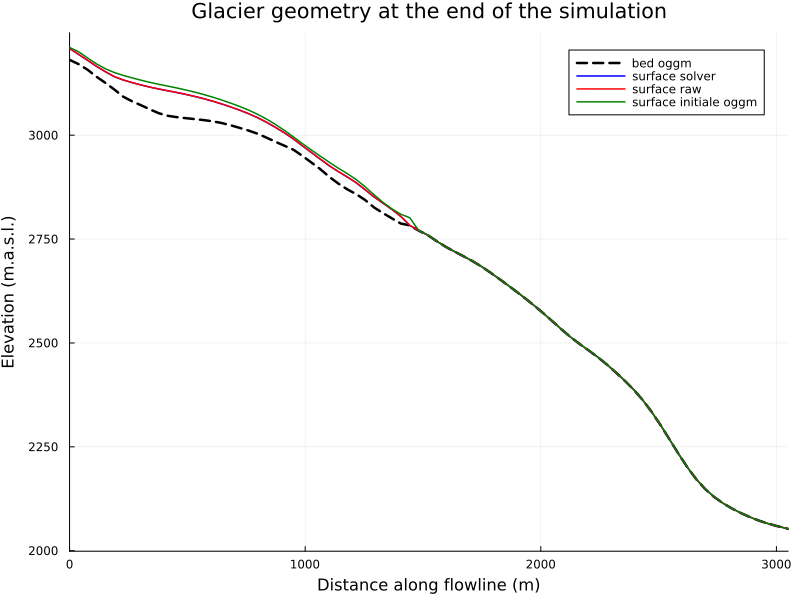

In [32]:
#Plotting the results
begin 
    plot(xc,bed_o, c="black",label="bed oggm",size=(800, 600),lw=2.5,ls=:dash,
    title="Glacier geometry at the end of the simulation",ylabel="Elevation (m.a.s.l.)",
    xlabel="Distance along flowline (m)")
    plot!(xc,iceflow_sol[end] .+ bed_o, c="blue",label="surface solver",lw=1.5)
    plot!(xc,surface_h, color="red", label="surface raw",lw=1.5)
    plot!(xc,surface_o,color="green",label="surface initiale oggm",lw=1.5)
    xlims!(0,3050)
end
